**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable - Parte 1

In [1]:
#Importamos librerías
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context('talk') #Seaborn graph format
pd.options.display.float_format = '{:20,.2f}'.format #Supress scientific notation

In [2]:
#Cargamos el dataframe y se le asigna un nombre (df)
df = pd.read_csv('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv')

In [3]:
# Se definen las columnas a utilizar a lo largo del entregable
relevant_columns = ['work_province','profile_years_experience','salary_monthly_NETO','tools_frameworks', 'tools_programming_languages','work_contract_type', 'salary_monthly_BRUTO', 'profile_studies_level', 'profile_studies_level_state']  #add salary_monthly_BRUTO & profile_studies_level  para el analisis de correlatividad

In [4]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')\
    .replace('ninguno', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = df.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.
df_lang[:5]

,programming_language,work_province,profile_years_experience,salary_monthly_NETO,tools_frameworks,tools_programming_languages,work_contract_type,salary_monthly_BRUTO,profile_studies_level,profile_studies_level_state,cured_programming_languages
1,html,Corrientes,5.00,"63,000.00","Django, jQuery","HTML, Javascript, Python",Full-Time,"79,000.00",Universitario,En curso,"[html, javascript, python]"
1,javascript,Corrientes,5.00,"63,000.00","Django, jQuery","HTML, Javascript, Python",Full-Time,"79,000.00",Universitario,En curso,"[html, javascript, python]"
1,python,Corrientes,5.00,"63,000.00","Django, jQuery","HTML, Javascript, Python",Full-Time,"79,000.00",Universitario,En curso,"[html, javascript, python]"
3,bash/shell,Corrientes,15.00,"102,000.00","jQuery, WordPress","Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",Full-Time,"130,000.00",Posgrado,Incompleto,"[bash/shell, c, css, html, java, javascript, p..."
3,c,Corrientes,15.00,"102,000.00","jQuery, WordPress","Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",Full-Time,"130,000.00",Posgrado,Incompleto,"[bash/shell, c, css, html, java, javascript, p..."


# Ejercicio 1 - Análisis descriptivo

Responder a la pregunta: **¿Cuáles son los lenguajes de programación asociados a los mejores salarios?**

Para ello:

1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en una sub-población. Por ejemplo, se pueden limitar a personas con un salario mayor que 10000 pesos, o a las personas que trabajan sólo en "Data Science", pero deben justificar su elección y reformular la pregunta inicial de ser necesario.
  * Obtener una lista de los lenguajes de programación más populares. Decidir cuántos y cuáles seleccionan para incluir en el análisis.
  * Para cada una de las otras columnas del punto anterior, elegir los rangos o valores seleccionan para incluir en el análisis.
3. Seleccionar métricas que ayuden a responder la pregunta, y los métodos para analizarlas. Elegir UNA de las siguientes opciones:
  * Comparar las distribuciones de salario para cada lenguaje utilizando visualizaciones. Como la visualización es el producto final, debe ser clara y mostrar información relevante.
  * Comparar medidas de estadística descriptiva sobre la distribución de salario para cada lenguaje. Sean creativos, la estadística descriptiva nos permite decir cosas como: "el 10% de los mejores sueldos los ganan, en su mayoría, programadores que saben kotlin!" (donde *mayoría* es un término medio engañoso que sólo significa más del 50%). Para comparar múltiples lenguajes, les recomendamos usar también visualizaciones.
  * Comparar probabilidades. Por ejemplo: "Si sabés Python o Java, tenés un 30% más de chances de ganar arriba de 100K".

1. 

Las columnas que seleccionamos fueron:
* **Lenguaje de programación**: Es una de las variables a analizar.
* **Sueldo neto**: Es la otra variable a analizar. Elegimos este en vez del sueldo bruto porque representa lo que efectivamente percibe el programador.
* **Provincia**: La usamos como variable de filtro. Hay provincias con costos de vida disímiles (por ejemplo, en las provincias del norte los sueldos suelen ser más bajos) y dejamos las de la región centro ya que son las más representativas por cantidad de gente y tienen costos de vida similares.
* **Tipo de contrato**: La usamos como variable de filtro. Descartamos aquellos programadores que trabajan part-time ya que al trabajar menos horas los sueldos no son comparables.
* **Años de experiencia**: Esta variable la categorizaremos y la usaremos para enriquecer el análisis. Nuestra teoría es que dentro de un mismo lenguaje de programación el sueldo puede variar en base al grado de experiencia.




A la hora de filtrar por filas se tomaron los siguientes criterios:
* **Provincia**: Dejamos solo las de la región centro: Ciudad Autónoma de Buenos Aires, Gran Buenos Aires, Provincia de Buenos Aires, Santa Fe y Córdoba
* **Sueldo neto**: Hallamos que habían muchas respuestas con sueldos netos de menos de 1000 pesos. Supusimos que muchos de quienes respondieron lo expresaron en miles, pero al no estar seguros preferimos filtrar todos aquellos que perciben menos de un salario mínimo vital y móvil del momento de la encuesta ($16875 en agosto de 2020).
* **Tipo de contrato**: Eliminamos aquellos programadores que trabajan de forma Part-Time. 
*  **Lenguaje de programación**: Filtramos aquellos que dijeran "ninguno", "ninguno de los anteriores" o valores nulos y tomamos aquellos que tuvieran frecuencia mayor o igual a 50 para asegurar mayor representatividad. Posteriormente, decidimos tomar los 10 lenguajes asociados a los salarios más altos para analizarlos en mayor profundidad asociándolos a otras variables como grado de experiencia y tipo de contrato.

In [5]:
#Filtros de filas

##Tipo de trabajo
df_lang = df_lang[df_lang['work_contract_type']!='Part-Time']

##Provincia 
provincias = ['Ciudad Autónoma de Buenos Aires','GBA','Provincia de Buenos Aires','Córdoba','Santa Fe']
df_lang = df_lang[df_lang['work_province'].isin(provincias)]

##Sueldo neto
sueldo_minimo = 16875 #sueldo minimo vital y móvil en Agosto 2020
q_max = df['salary_monthly_NETO'].quantile(0.98)
df_lang = df_lang[(df_lang['salary_monthly_NETO'] > sueldo_minimo) & (df_lang['salary_monthly_NETO'] < q_max)]

##Frequencia de lenguaje
freq = df_lang['programming_language'].value_counts()
freq_lang = freq[freq >= 50].index
df_lang = df_lang[df_lang['programming_language'].isin(freq_lang)]

In [6]:
#Variable categórica de experiencia
criterios = [df_lang['profile_years_experience']<2, (df_lang['profile_years_experience']>= 2) & (df_lang['profile_years_experience']< 5), df_lang['profile_years_experience']>=5]
etiquetas = ['Junior','Semi-Senior','Senior']

df_lang['experiencia'] = np.select(criterios, etiquetas)

In [7]:
df_lang.head()

,programming_language,work_province,profile_years_experience,salary_monthly_NETO,tools_frameworks,tools_programming_languages,work_contract_type,salary_monthly_BRUTO,profile_studies_level,profile_studies_level_state,cured_programming_languages,experiencia
4,css,Ciudad Autónoma de Buenos Aires,9.00,"106,000.00","Angular, Node.js","CSS, HTML, Javascript, SQL, TypeScript",Full-Time,"140,000.00",Universitario,En curso,"[css, html, javascript, sql, typescript]",Senior
4,html,Ciudad Autónoma de Buenos Aires,9.00,"106,000.00","Angular, Node.js","CSS, HTML, Javascript, SQL, TypeScript",Full-Time,"140,000.00",Universitario,En curso,"[css, html, javascript, sql, typescript]",Senior
4,javascript,Ciudad Autónoma de Buenos Aires,9.00,"106,000.00","Angular, Node.js","CSS, HTML, Javascript, SQL, TypeScript",Full-Time,"140,000.00",Universitario,En curso,"[css, html, javascript, sql, typescript]",Senior
4,sql,Ciudad Autónoma de Buenos Aires,9.00,"106,000.00","Angular, Node.js","CSS, HTML, Javascript, SQL, TypeScript",Full-Time,"140,000.00",Universitario,En curso,"[css, html, javascript, sql, typescript]",Senior
4,typescript,Ciudad Autónoma de Buenos Aires,9.00,"106,000.00","Angular, Node.js","CSS, HTML, Javascript, SQL, TypeScript",Full-Time,"140,000.00",Universitario,En curso,"[css, html, javascript, sql, typescript]",Senior


Una vez seleccionadas las columnas relevantes y aplicados los filtros pertinentes procedemos a obtener algunos números resumen para los salarios por lenguaje de programación. Calculamos la cantidad de ocurrencias, la media, desviación estándar, cuantiles 0, 25, 50, 75 y 100. Todos los resultados están reflejados en la tabla a continuación, que se ordenó por la mediana, que nos pareció la métrica más relevante para determinar que lenguajes están asociados a mejores salarios. 
Elegimos la mediana como la métrica más relevante ya que al observar en los gráficos que siguen la distribuciones para cada tipo de lenguaje distinto, se evidencia que hay presencia de sesgo para varios lenguajes, de esa manera, la mediana resulta ser más indicativa que la media. 

In [8]:
df_resumen = df_lang.groupby('programming_language').describe().salary_monthly_NETO

df_resumen.sort_values('mean', ascending=False)#[['mean','50%','count']]

,count,mean,std,min,25%,50%,75%,max
programming_language,,,,,,,,
scala,86.00,"134,745.12","51,872.03","44,000.00","93,487.50","131,000.00","166,500.00","320,000.00"
go,233.00,"126,782.55","58,201.59","35,000.00","86,500.00","110,000.00","150,000.00","360,000.00"
ruby,105.00,"122,689.28","68,960.30","30,000.00","75,382.00","105,000.00","150,000.00","348,585.00"
kotlin,146.00,"120,721.19","53,960.85","30,000.00","86,825.00","113,000.00","148,250.00","350,000.00"
groovy,136.00,"118,793.15","64,675.83","20,000.00","79,547.50","100,000.00","139,821.50","360,000.00"
swift,81.00,"118,100.93","63,454.08","40,000.00","75,000.00","100,000.00","140,000.00","364,000.00"
python,"1,177.00","103,757.18","56,558.56","20,000.00","67,800.00","91,000.00","120,000.00","368,300.00"
r,70.00,"102,752.51","65,130.49","30,000.00","67,225.00","84,650.00","110,250.00","350,000.00"
cobol,69.00,"102,626.09","48,971.49","35,000.00","73,000.00","95,000.00","112,000.00","280,000.00"


A primera vista, una de las conclusiones que obtuvimos fue que los lenguajes más populares no están directamente relacionados con los mejores salarios. Html por ejemplo, se encuentra al final de la tabla, mientras que java está varias posiciones por encima. Así que a la hora de graficar para observar mejor los datos decidimos hacerlo de dos formas: tomando los lenguajes más populares y tomando los mejores pagos.

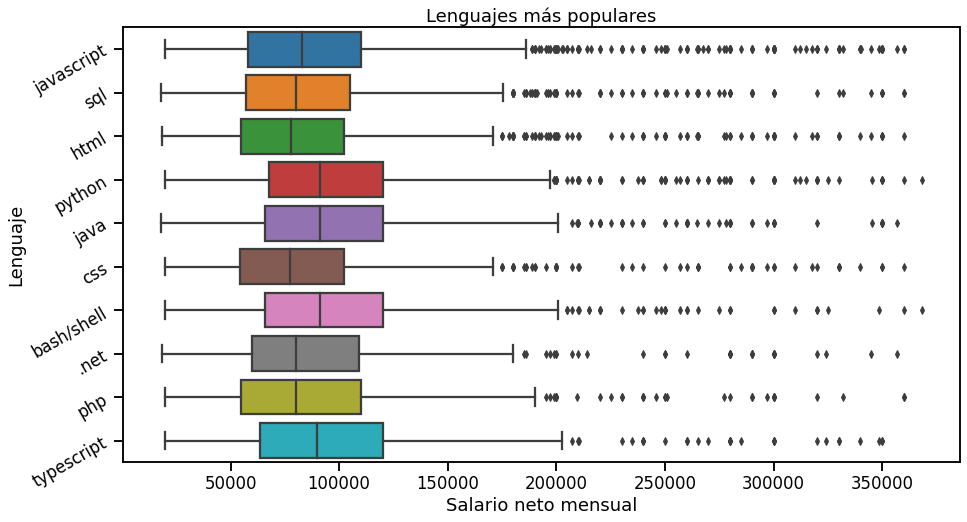

In [9]:
##Top 10 lenguajes más populares
top_lang = df_resumen.sort_values('count', ascending=False).head(10).index.to_list()
df_boxplot = df_lang[df_lang['programming_language'].isin(top_lang)]

#Boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_boxplot, x="salary_monthly_NETO", y="programming_language", order=top_lang)
plt.title('Lenguajes más populares')
plt.xlabel('Salario neto mensual')
plt.ylabel('Lenguaje')
plt.yticks(rotation=30)
plt.ticklabel_format(style='plain', axis='x')

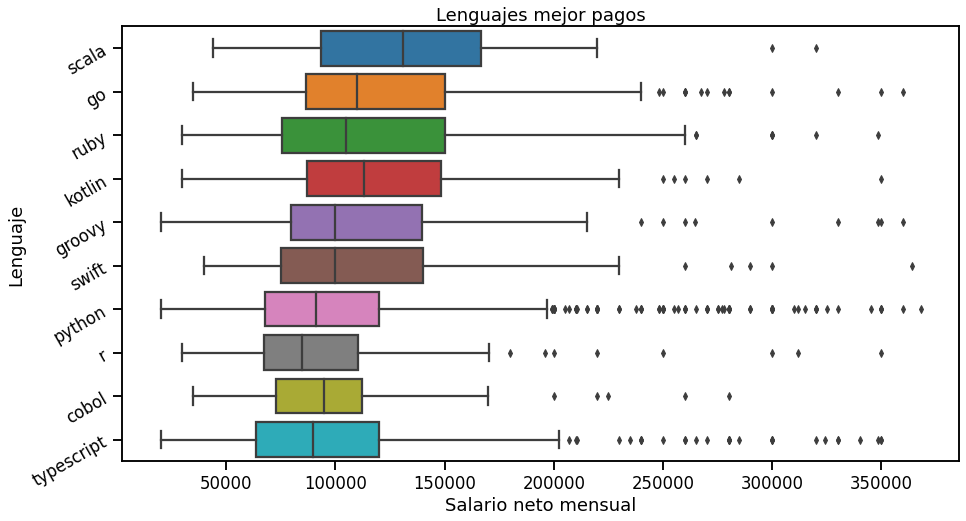

In [10]:
##Top 10 medias más altas
top_wage = df_resumen.sort_values('mean', ascending=False).head(10).index.to_list()
df_boxplot = df_lang[df_lang['programming_language'].isin(top_wage)]

#Boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_boxplot, x="salary_monthly_NETO", y="programming_language", order=top_wage)
plt.title('Lenguajes mejor pagos')
plt.xlabel('Salario neto mensual')
plt.ylabel('Lenguaje')
plt.yticks(rotation=30)
plt.ticklabel_format(style='plain', axis='x')

Para profundizar el análisis decidimos cruzar la variable de salario con el grado de experiencia y el tipo de contrato, para ver si podemos obtener una mayor cantidad de información relevante.


In [11]:
#Datos cruzados con experiencia
df_exp = df_lang.groupby(['programming_language','experiencia']).describe().salary_monthly_NETO
df_exp = df_exp.reset_index()
df_exp = df_exp[df_exp['programming_language'].isin(top_wage)]

In [12]:
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

palette = cycle(px.colors.qualitative.Plotly)

language = top_wage

fig = go.Figure()
fig.add_trace(go.Bar(
    y=language,
    x=df_exp[df_exp['experiencia']=='Junior']['mean'],
    name='Junior',
    orientation='h',
    marker_color=next(palette)
))
fig.add_trace(go.Bar(
    y=language,
    x=df_exp[df_exp['experiencia']=='Semi-Senior']['mean'],
    name='Semi-Senior',
    orientation='h',
    marker_color=next(palette)
))
fig.add_trace(go.Bar(
    y=language,
    x=df_exp[df_exp['experiencia']=='Senior']['mean'],
    name='Senior',
    orientation='h',
    marker_color=next(palette)
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group')
fig.show()


##Código para verlo en seaborn
#plt.figure(figsize=(15, 8))
#sns.catplot(data=df_exp, kind='bar', y='programming_language', x='50%', hue='experiencia', order=top_wage)
#plt.title('Lenguajes mejor pagos')
#plt.xlabel('Salario neto mensual')
#plt.ylabel('Lenguaje')

In [13]:
#Datos cruzados con tipo de contrato
df_exp2 = df_lang.groupby(['programming_language','work_contract_type']).describe().salary_monthly_NETO
df_exp2 = df_exp2.reset_index()

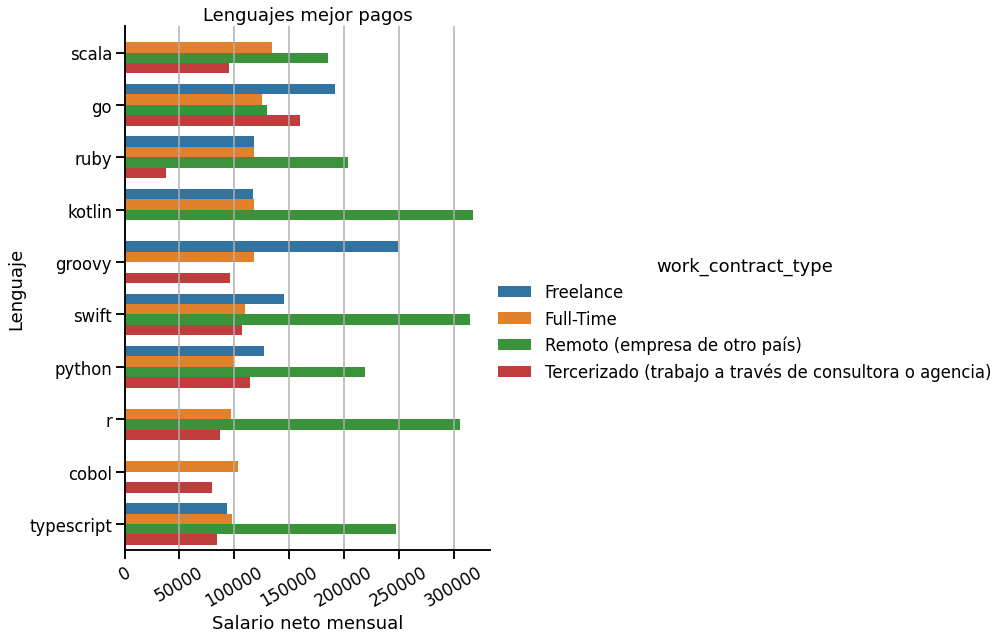

In [14]:
#Lenguajes mejor pagos
sns.catplot(data=df_exp2, kind='bar', y='programming_language', x='mean', hue='work_contract_type',order=top_wage,  height=8)
plt.title('Lenguajes mejor pagos')
plt.xlabel('Salario neto mensual')
plt.ylabel('Lenguaje')
plt.xticks(rotation=30)
plt.grid(axis="x")

#Lenguajes más populares
#sns.catplot(data=df_exp2, kind='bar', y='programming_language', x='50%', hue='work_contract_type',order=top_lang,  height=8)
#plt.title('Lenguajes más populares')
#plt.xlabel('Salario neto mensual')
#plt.ylabel('Lenguaje')
#plt.xticks(rotation=30)
#plt.grid(axis="x")



---


## Conclusiones finales ejercicio 1

En base a los distintos análisis realizados, las principales conclusiones que obtuvimos fueron las siguientes:
- Los lenguajes más populares no son los mejores pagos (aunque hay algunas excepciones como en el caso de Python y Typescript)
- El grado de seniority es una variable que influye de forma importante y a todos los lenguajes por igual. No podemos concluir que convenga ser desarrollador junior de un lenguaje en vez de desarrollador senior de otro.
- El tipo de contrato es una variable que marca muchas diferencias. En primer lugar conviene claramente trabajar de forma remota. En segundo lugar, cuando el tipo de contrato es full-time, las diferencias entre lenguajes se reducen.

Si tuvieramos que hacer una sugerencia en base a los datos que vimos, diríamos que lo más importante quizas no es el tipo de lenguaje, sino el poder trabajar para empresas del exterior ;)


---



---



# Ejercicio 2 - Densidades y varias varialbes

Responder a la pregunta general: **¿Que herramientas (prácticas y teóricas) són útiles para explorar la base, descubrir patrones, asociaciones?**

Para ello considere (igual al ejercicio Anterior):
* Seleccionar las columnas relevantes para analizar.
* Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en sub-poblaciones.

## a) Densidad conjunta

Que herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos? 

Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. Puede describir de alguna forma el comportamiento de sus datos? Que herramientas utilizaría? Describa




Las variables que seleccionamos fueron:

1. Numéricas:
* Sueldo neto
* Sueldo bruto
* Años de experiencia 

2. Categóricas:
* Provincia
* Tipo de contrato



A la hora de analizar podríamos usar los siguientes gráficos:
* Boxenplot: Para cruzar una variable numérica (sueldo neto) y una categórica (provincia)
* Scatterplot: Para cruzar dos variable numéricas (sueldo neto y años de experiencia) y una categórica (tipo de contrato).
* Heatmap: Para cruzar las frecuencias de dos variables categóricas (provincia y tipo de contrato)



In [15]:
#Vamos a usar un df distinto por ejercicio

##Filtros de sueldo neto y bruto
sueldo_minimo = 16875 #sueldo minimo vital y móvil en Agosto 2020
q_max_neto = df['salary_monthly_NETO'].quantile(0.95)
q_max_bruto = df['salary_monthly_BRUTO'].quantile(0.95)

df_2a = df[(df['salary_monthly_NETO'] > sueldo_minimo) & (df['salary_monthly_NETO'] < q_max_neto)]
df_2a = df_2a[(df_2a['salary_monthly_BRUTO'] > sueldo_minimo) & (df_2a['salary_monthly_BRUTO'] < q_max_bruto)]


##Provincia 
provincias = ['Ciudad Autónoma de Buenos Aires','GBA','Provincia de Buenos Aires','Córdoba','Santa Fe']
df_2a = df_2a[df_2a['work_province'].isin(provincias)]

criterios = [df_2a['work_province']=='Ciudad Autónoma de Buenos Aires', df_2a['work_province']=='Provincia de Buenos Aires']
etiquetas = ['CABA','Prov. Bs As']
df_2a['work_province'] = np.select(criterios, etiquetas, default=df_2a['work_province'])


##Tipo de contrato
criterios = [df_2a['work_contract_type']=='Tercerizado (trabajo a través de consultora o agencia)',df_2a['work_contract_type']=='Remoto (empresa de otro país)']
etiquetas = ['Tercerizado','Remoto']
df_2a['work_contract_type'] = np.select(criterios, etiquetas, default=df_2a['work_contract_type'])

##Filtramos errores en experiencia
df_2a = df_2a[df_2a['profile_years_experience']<df_2a['profile_age']]

##Variable categórica de experiencia
criterios = [df_2a['profile_years_experience']<2, (df_2a['profile_years_experience']>= 2) & (df_2a['profile_years_experience']< 5), df_2a['profile_years_experience']>=5]
etiquetas = ['Junior','Semi-Senior','Senior']

df_2a['experiencia'] = np.select(criterios, etiquetas)


#Dejamos solo columnas relevantes para este ejercicio y los próximos
df_2a = df_2a[['salary_monthly_NETO','salary_monthly_BRUTO','profile_years_experience','experiencia','work_province','work_contract_type','profile_studies_level','profile_studies_level_state']]

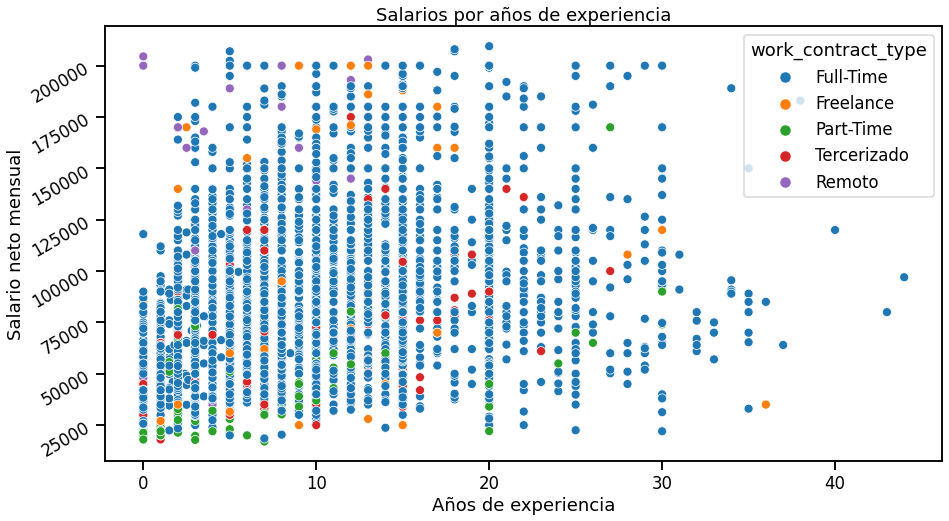

In [16]:
#Lenguajes mejor pagos
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df_2a, x="profile_years_experience", y='salary_monthly_NETO', hue='work_contract_type')
plt.title('Salarios por años de experiencia')
plt.ylabel('Salario neto mensual')
plt.xlabel('Años de experiencia')
plt.yticks(rotation=30)
plt.ticklabel_format(style='plain', axis='x')


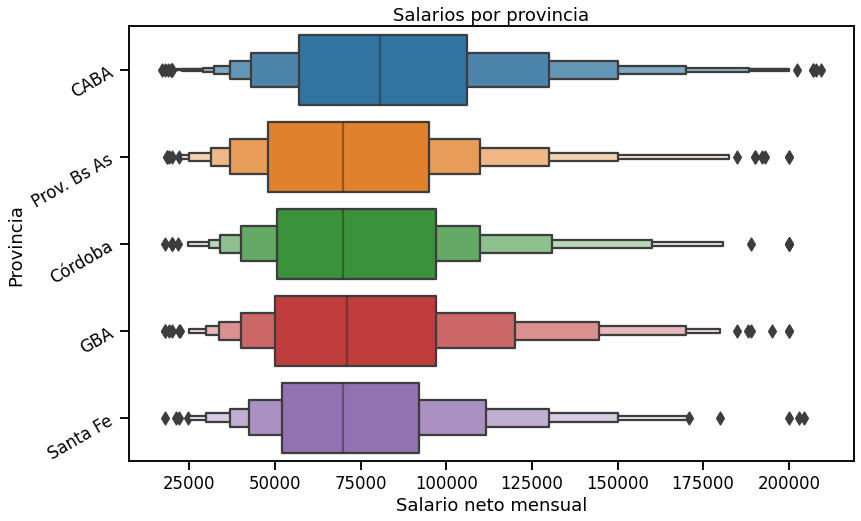

In [17]:
#Boxplot
plt.figure(figsize=(13, 8))
sns.boxenplot(data=df_2a, x="salary_monthly_NETO", y="work_province")
plt.title('Salarios por provincia')
plt.xlabel('Salario neto mensual')
plt.ylabel('Provincia')
plt.yticks(rotation=30)
plt.ticklabel_format(style='plain', axis='x')

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

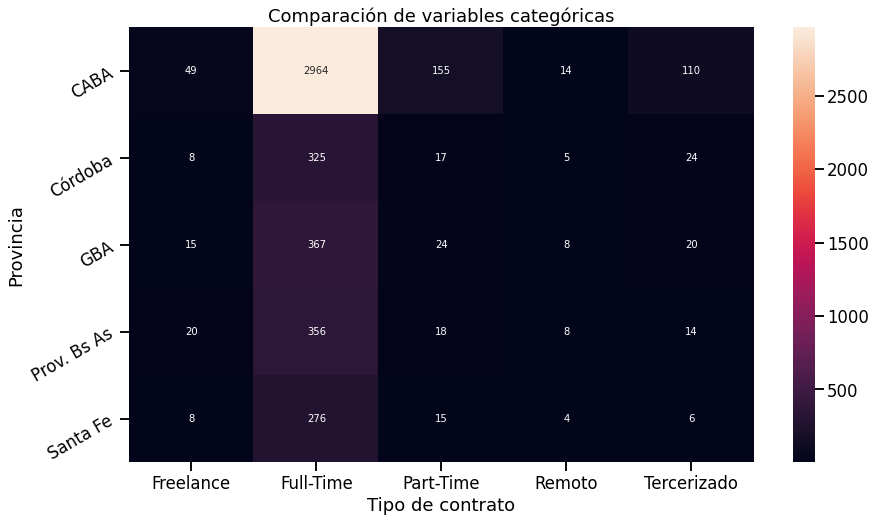

In [18]:
#Heatmap (es necesario darle forma a los datos, usamos la función crosstab para eso)
plt.figure(figsize=(14, 8))
sns.heatmap(pd.crosstab(index=df_2a.work_province, columns=df_2a.work_contract_type), annot=True, fmt = 'g')
plt.title('Comparación de variables categóricas')
plt.xlabel('Tipo de contrato')
plt.ylabel('Provincia')
plt.yticks(rotation=30)

## b) Asociación

* Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple.
¿Existe una correlación entre el salario bruto y el neto? Que abordaje y medidas usaría



1. Agregamos el salario bruto al df_lang para poder hacer la correlacion con el df que estamos manejando
2. Creamos un nuevo df con solo las columnas que hacen falta
3. La correlación de Pearson funciona bien con variables cuantitativas que tienen una distribución normal o próxima a la normal. Es más sensible a los valores extremos que las otras dos alternativas.
4. Se emplean como medida de la fuerza de asociación entre dos variables (tamaño del efecto):
  * 0: asociación nula.
  * 0.1: asociación pequeña.
  * 0.3: asociación mediana.
  * 0.5: asociación moderada.
  * 0.7: asociación alta.
  * 0.9: asociación muy alta.

In [19]:
#Tomo solo las columnas de sueldo del DF del ejercicio anterior (que ya tienen los filtros aplicados)
sueldos = df_2a[['salary_monthly_NETO','salary_monthly_BRUTO']]

In [20]:
correlacion_sueldos = sueldos['salary_monthly_NETO'].corr(sueldos['salary_monthly_BRUTO'])
print('(Metodo 3) Correlacion = ',correlacion_sueldos)
print('Con los filtros aplicados para outliers y valores mal cargados, se tiene una correlacion del',correlacion_sueldos,'. Esta')
print( 'correlacion lineal positiva de asociacion muy alta nos permite ignorar la columna de salary_monthly_BRUTO en nuestro analisis')

(Metodo 3) Correlacion =  0.9653401955191326
Con los filtros aplicados para outliers y valores mal cargados, se tiene una correlacion del 0.9653401955191326 . Esta
correlacion lineal positiva de asociacion muy alta nos permite ignorar la columna de salary_monthly_BRUTO en nuestro analisis


<Figure size 1008x576 with 0 Axes>

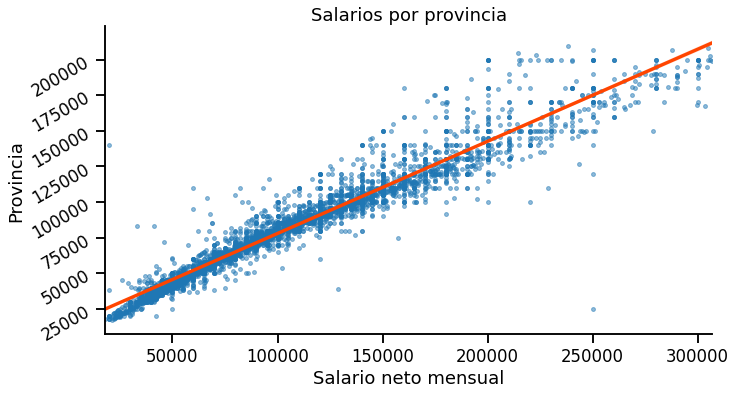

In [21]:
#Lenguajes mejor pagos
plt.figure(figsize=(14, 8))
sns.lmplot(data=sueldos, x="salary_monthly_BRUTO", y='salary_monthly_NETO', aspect=2, line_kws={'color': 'orangered'}, scatter_kws={"s": 15, "alpha":0.5})
plt.title('Salarios por provincia')
plt.xlabel('Salario neto mensual')
plt.ylabel('Provincia')
plt.yticks(rotation=30)
plt.ticklabel_format(style='plain', axis='x')



---


### Conclusión:
Con los filtros aplicados para outliers y valores mal cargados, se tiene una correlación de Pearson del  0.9432309946924591 . Esta correlación lineal positiva de asociación muy alta nos permite fundamentar el decidir sacar la columna de salary_monthly_BRUTO de nuestro analisis.


---



## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación

In [22]:
print("Descripción niveles de Estudio.")

tablita = pd.crosstab(df_2a["profile_studies_level"], df_2a["profile_studies_level_state"])
tablita["Totales"]=[sum(tablita.iloc[i]) for i in range(tablita.shape[0])]
tablita

Descripción niveles de Estudio.


profile_studies_level_state,Completado,En curso,Incompleto,Totales
profile_studies_level,,,,
Doctorado,5,11,4,20
Posdoctorado,2,0,0,2
Posgrado,162,70,21,253
Primario,2,0,0,2
Secundario,322,8,41,371
Terciario,534,198,201,933
Universitario,1219,1139,891,3249


Elegimos las subpoblaciones **Universitario** y **Terciario**, que son las más numerosas.

In [23]:
#Filtro DF dejando las subpoblaciones de interés
df_uni_ter = df_2a[df_2a['profile_studies_level'].isin(['Universitario','Terciario'])]


#Números resumen para comparar
df_uni_ter.groupby('profile_studies_level').describe().salary_monthly_NETO

,count,mean,std,min,25%,50%,75%,max
profile_studies_level,,,,,,,,
Terciario,933.00,"75,868.86","34,921.31","18,000.00","50,000.00","70,000.00","93,000.00","200,000.00"
Universitario,"3,249.00","83,754.70","36,553.14","17,800.00","55,550.75","80,000.00","105,000.00","209,480.00"


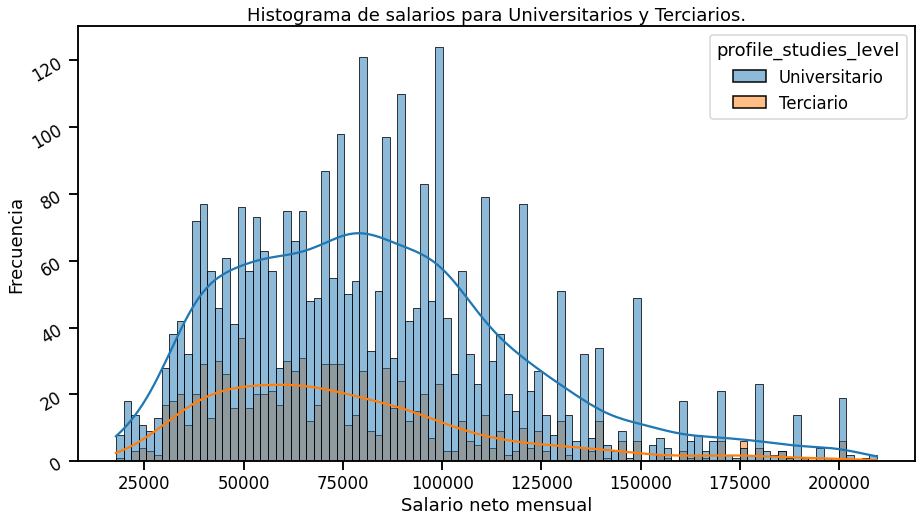

In [39]:
fig = plt.figure(figsize=(15,8))
histograma =sns.histplot(data=df_uni_ter, x="salary_monthly_NETO", hue ='profile_studies_level', bins=100,kde=True )
plt.title("Histograma de salarios para Universitarios y Terciarios.")
plt.xlabel('Salario neto mensual')
plt.ylabel('Frecuencia')
plt.yticks(rotation=30)
plt.ticklabel_format(style='plain', axis='x')

En el histograma se nota la mayor proporción de universitarios (3801) que terciarios (1049). También, de la forma de las curvas, parece ser mayor el ingreso medio de un universitario.

Queremos determinar si hay independencia entre las variables nivel de ingresos vs nivel de estudios alcanzados. Nos vamos a restringir a comparar entre las 2 subpoblaciones de niveles de estudio más grandes, los universitarios y los terciarios. 

Lo primero que hacemos es obtener la población total y la población de universitarios. 

In [25]:
cantidad_programadores=len(df_2a) # 5600
cantidad_universitarios=len(df_2a[df_2a["profile_studies_level"] == "Universitario"]) # 3801

Vamos a construir un DataFrame que nos ayude a decidir si hay independencia entre las variables. La idea es, dado un nivel de salario (ej: $50000), hallar la probabilidad de que un programador tenga ingresos superiores a ese monto. Y por otro lado, hallar la probabilidad de que un universitario tenga ingresos superiores a ese monto. Si **NIVEL de ESTUDIOS** vs **NIVEL de INGRESOS** fueran independientes, estas probabilidades deberían ser similares para varios niveles de salario. Llamaremos al DataFrame **salario_vs_estudios**.

In [26]:
salario_millar=[]
proba=[]
proba_uni=[]
cociente=[]

for i in range(1000*int(sueldo_minimo/1000), int(max(df_uni_ter.salary_monthly_NETO)/1000)*1000, 1000):
  salario_millar.append(i)
  prob1=len(df_uni_ter[df_uni_ter["salary_monthly_NETO"] > i])/cantidad_programadores
  prob2=len(df_uni_ter[(df_uni_ter["salary_monthly_NETO"] > i) & (df_uni_ter["profile_studies_level"] == "Universitario")])/cantidad_universitarios
  proba.append(prob1)
  proba_uni.append(prob2)
  cociente.append(prob2/prob1)

data = {'Nivel_Salario':salario_millar, 'Prob':proba, "Prob_Uni":proba_uni, "Cociente":cociente}
salario_vs_estudios = pd.DataFrame(data)

In [27]:
salario_vs_estudios.head(15)

,Nivel_Salario,Prob,Prob_Uni,Cociente
0,16000,0.87,1.00,1.15
1,17000,0.87,1.00,1.15
2,18000,0.86,1.00,1.15
3,19000,0.86,1.00,1.15
4,20000,0.86,0.99,1.15
5,21000,0.86,0.99,1.15
6,22000,0.86,0.99,1.15
7,23000,0.86,0.99,1.15
8,24000,0.86,0.99,1.15
9,25000,0.85,0.98,1.15


Cómo se lee el DataFrame **salario_vs_estudios** ?

La columna **Prob** nos dice la probabilidad de que un programador tenga un salario superior al del campo **Nivel_Salario** que está en su misma fila.

La columna **Prob_Uni** nos dice la probabilidad de que un universitario tenga un salario superior al del campo **Nivel_Salario** que está en su misma fila.

La columna **Cociente** es el cociente **(Prob)/(Prob_Uni)**

Por ejemplo, el 84% de los programadores ganan más de 25000 pesos. 
A su vez 97% de los universitarios ganan más de 25000 pesos. Y por lo tanto, un universitario tiene un 15% más de probabilidades de ganar 25000 pesos que un programador.


In [28]:
salario_vs_estudios[salario_vs_estudios.Nivel_Salario==50000]

,Nivel_Salario,Prob,Prob_Uni,Cociente
34,50000,0.68,0.80,1.18


Otro ejemplo; el 67% de los programadores ganan más de 50000 pesos. 
A su vez 79% de los universitarios ganan más de 50000 pesos. Y por lo tanto, un universitario tiene un 18% más de probabilidades de ganar 50000 pesos que un programador.


In [29]:
minimo=min(salario_vs_estudios["Cociente"])
minimo

1.152384004024347

El mínimo de la columna cociente es mayor a $1.15$. Es decir, que para todos los niveles de salario de a partir de 18000, siempre la probabilidad de que un universitario gane al menos ese dinero es por lo menos un 15% mayor a la de que lo haga un programador.

Por lo tanto, de comparar Universitarios y Terciarios, resulta que las variables NIVEL de ESTUDIOS y NIVEL de INGRESOS **no son independientes**.

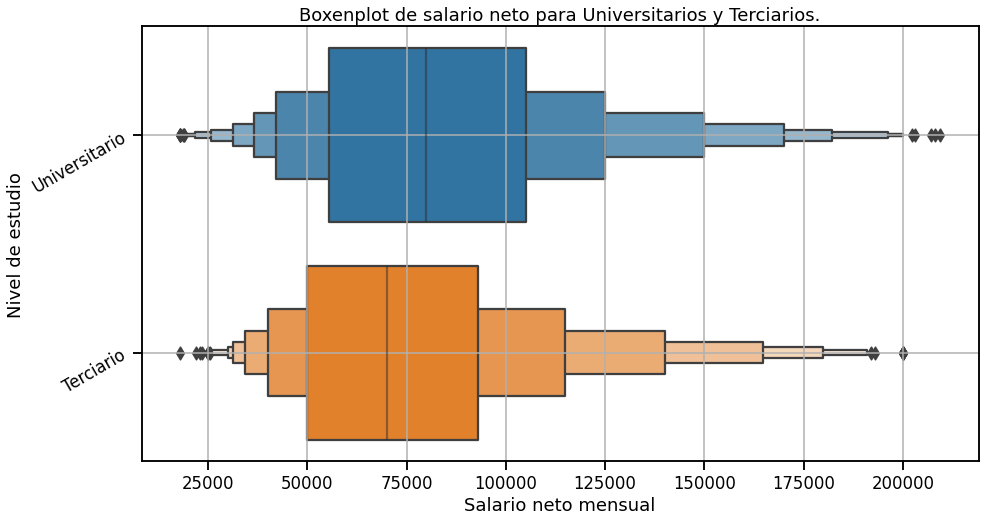

In [40]:
plt.figure(figsize=(15, 8))
sns.boxenplot(data=df_uni_ter, x="salary_monthly_NETO", y='profile_studies_level')
plt.grid()
plt.title("Boxenplot de salario neto para Universitarios y Terciarios.")
plt.xlabel('Salario neto mensual')
plt.ylabel('Nivel de estudio')
plt.yticks(rotation=30)
plt.ticklabel_format(style='plain', axis='x')

In [49]:
#plt.figure(figsize=(15, 8))
#sns.boxplot(data=df_uni_ter, x="salary_monthly_NETO", y='profile_studies_level', hue='profile_studies_level_state')


Al graficar el boxplot se pueden observar largas colas por lo que preferimos realizar un boxenplot que ofrece mayor cantidad de info al respecto.

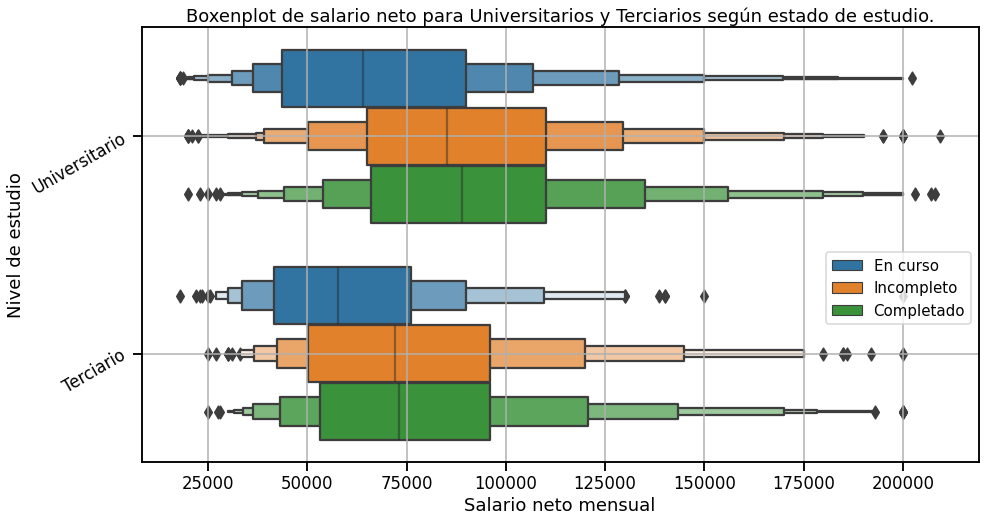

In [47]:
plt.figure(figsize=(15, 8))
sns.boxenplot(data=df_uni_ter, x="salary_monthly_NETO", y='profile_studies_level', hue='profile_studies_level_state')
plt.grid()
plt.legend(loc="upper right", bbox_to_anchor=(1, 0.5), 
           fontsize=15)
plt.title("Boxenplot de salario neto para Universitarios y Terciarios según estado de estudio.")
plt.xlabel('Salario neto mensual')
plt.ylabel('Nivel de estudio')
plt.yticks(rotation=30)
plt.ticklabel_format(style='plain', axis='x')

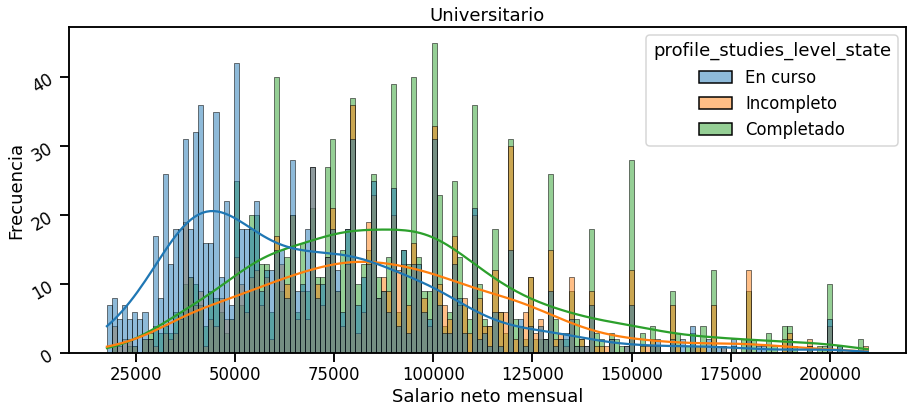

In [51]:
fig = plt.figure(figsize=(15,6))
histograma = sns.histplot(data=df_uni_ter[df_uni_ter.profile_studies_level=="Universitario"], x="salary_monthly_NETO", hue ='profile_studies_level_state', bins=150,kde=True )
plt.title("Universitario")
plt.xlabel('Salario neto mensual')
plt.ylabel('Frecuencia')
plt.yticks(rotation=30)
plt.ticklabel_format(style='plain', axis='x')

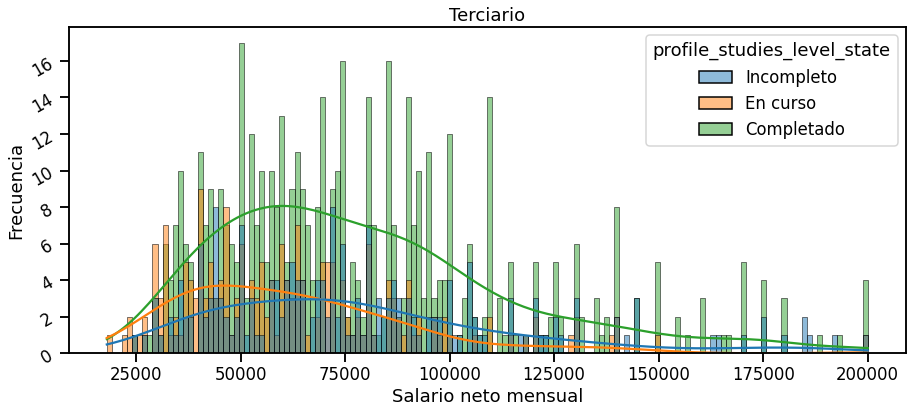

In [53]:
fig = plt.figure(figsize=(15,6))
histograma = sns.histplot(data=df_uni_ter[df_uni_ter.profile_studies_level=="Terciario"], x="salary_monthly_NETO", hue ='profile_studies_level_state', bins=150,kde=True )
plt.title("Terciario")
plt.xlabel('Salario neto mensual')
plt.ylabel('Frecuencia')
plt.yticks(rotation=30)
plt.ticklabel_format(style='plain', axis='x')

**Conclusiones**
Las variables nivel de estudio y salario neto no son independientes.


## d) Densidad Conjunta condicional

Elija dos variables numéricas y una categórica. 
Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)

In [ ]:
plt.figure(figsize=(20, 8))
scatter=sns.scatterplot(data=df_2a, x="profile_years_experience", y='salary_monthly_NETO', hue='profile_studies_level', palette= "colorblind")
scatter.set_xlim(right=50)
plt.title("Scatterplot salario neto vs años de experiencia según nivel de estudio")
plt.ylabel('Salario neto mensual')
plt.xlabel('Años de experiencia')
plt.yticks(rotation=30)
plt.ticklabel_format(style='plain', axis='x')

Al analizar los años de experiencia, el sueldo neto y el nivel de estudio, podemos ver que no hay una asociación clara entre las variables.